***
***
# <div align="center"><font color='BLUE'><b>AREEBA FATAH </b></font></div>
***
# <div align="center"><font color='BLUE'><b>GENERATIVE AI</b></font></div>
***
# <div align="center"><font color='indigo'><b>21I-0349</b></font></div>
***
# <div align="center"><font color='BLUE'><b>ASSIGNMENT 1</b></font></div>
***
# <div align="center"><font color='BLUE'><b>Task 1 CNN IMPLEMENTATION </b></font></div>
***
<br>

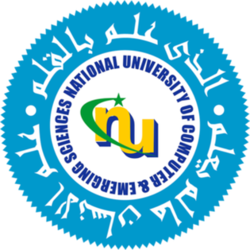<br>

## DESCRIPTION:
This tasks involves segmenting the signatures from grids
stored in an image, extracting features using CNN and clas-
sifying the signatures.More we do comparative analysis with
Hog and Sift feature extraction. The comparative analysis of
these involves visual representations and evaluation metrics
like accuracy score, f1 score.

# IMPORTING THE REQUIRED LIBRARIES

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import os
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# STEP 1: DATA PREPROCESSING AND PREPARATION

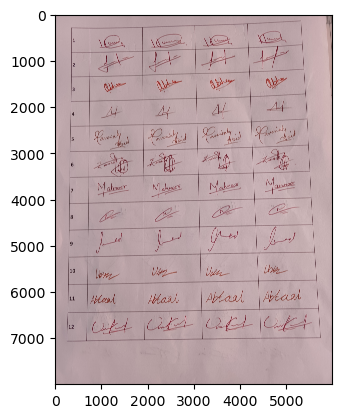

In [89]:
image=cv2.imread('Data/20240904_083201.jpg')
plt.imshow(image)

So we have 16 images , each image has 12 rows i.e. 12 people so in total we'll deal with 192 people along with grid lines, dealing with segmentation is definitely an important issue

## 1.1 IMAGE LOADING AND ROW EXTRACTION/DIVISION :
1)- Here i'll create a function for loading different images to avoid repetitive code.
<br>2)- Row Extraction assumes the dimensions of a box containing signatures and Id, this assumption is taken from the first image <br> provided in the dataset. It divides the image into rows each row belonging to one person.

In [5]:
'''
    1)- A function to just load the images
'''
def Signature_image_loader(signature_path):
    signatures_image=cv2.imread(signature_path)
    if signatures_image is None:
        print(f'Image at path {signature_path} has some issue loading,call a tech!')
    return signatures_image


'''
    2)- A function that takes an educated guess of dimensions and split the image on the basis of the rows.
        this guess is taken by manually checking the dimensions as the ones with approximation using code are worse than this.
        That's why, i have used this.
'''
def Signature_Row_Extraction(signatures_image):
    signatures_image_h,signatures_image_w=signatures_image.shape[:2]
    id_box_w=392
    box_width=1193
    box_height=525
    people_per_image=12
    rows_wise_Signatures=[]
    one_persons_row_height=box_height+100                               # for padding purpose
    for i in range(people_per_image):
        starting_index=i*one_persons_row_height
        ending_index=starting_index+one_persons_row_height
        one_row =signatures_image[starting_index:ending_index, :]
        rows_wise_Signatures.append(one_row)
    return rows_wise_Signatures

[[[173 157 164]
  [174 158 165]
  [174 158 165]
  ...
  [119  96 101]
  [124 102 107]
  [132 110 115]]]


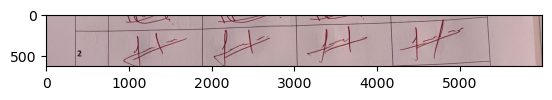

In [13]:
image=Signature_image_loader('Data/20240904_083201.jpg')
print(image[:1])
plt.imshow(Signature_Row_Extraction(image)[1])

## 1.2 REMOVING LINES AND PROCESSING SIGNATURES:
1)- the line remover function creates kernels for horizontal and vertical lines then gets the mask of the lines and subtract it <br>from the original image both horizontal and vertical lines should be removed to some extent to focus on image part.<br>
2)- the Process signs function converts the image to gray , removes noise with gaussian applies dilation for better connectivity<br> and converts the image to binary after creating contours, purpose to have clear image of signatures

In [23]:
'''
    3)- the line remover function creates kernels for horizontal and vertical lines then gets the mask of the lines and 
        subtract it from the original image both horizontal and vertical lines should be removed to some extent to 
        focus on image part.
'''
def Line_remover(signature_image):
    horizontal_k = cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1))
    vertical_k = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 40))
    horizontal_lines = cv2.morphologyEx(signature_image, cv2.MORPH_OPEN, horizontal_k, iterations=2)
    result = cv2.subtract(signature_image, horizontal_lines)
    vertical_lines = cv2.morphologyEx(result, cv2.MORPH_OPEN, vertical_k, iterations=2)
    return cv2.subtract(result, vertical_lines)



'''
    4)- the Process signs function converts the image to gray , removes noise with gaussian applies dilation for better
        connectivity and cinverts the image to binary after creating contours, purpose to have clear image of signatures
'''
def Process_Signs(signature_image):
    if signature_image.size==0:
        print("Received empty image for preprocessing.")
    signature_image=cv2.cvtColor(signature_image,cv2.COLOR_BGR2GRAY)
    signature_image=cv2.GaussianBlur(signature_image,(5,5),0)
    _, threshold=cv2.threshold(signature_image, 127, 255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    image_without_lines=Line_remover(threshold)
    kernel=np.ones((5,5),np.uint8)  
    dilated_image=cv2.dilate(image_without_lines,kernel, iterations=1)
    contours,_=cv2.findContours(dilated_image,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    mask=np.zeros_like(dilated_image)
    cv2.drawContours(mask, contours,-1,(255),thickness=cv2.FILLED)
    return cv2.bitwise_and(dilated_image,mask)

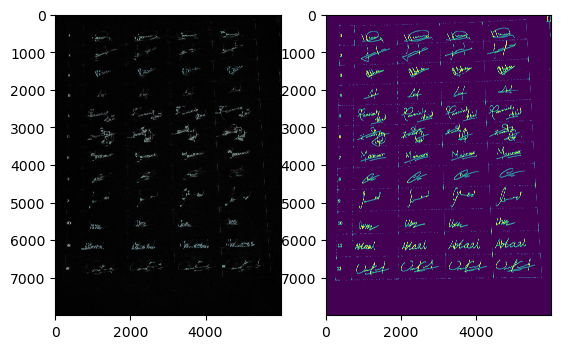

In [25]:
plt.subplot(1,2,1)
plt.imshow(Line_remover(image))

plt.subplot(1,2,2)
plt.imshow(Process_Signs(image))

## 1.3 STORING SIGNATURES OF PEOPLE FOR ALL IMAGES:
1)- The Signature extractor extracts signature per image with ids and stores them in the folders based on estimated dimensions.
<br> it stores both simple images for cnn and processed for hog and sift
<br>2)- The Process All images simply repeats the process for all images after getting rows and removing lines. 

In [37]:
'''
    5)- The Signature extractor extracts signature per image with ids and stores them in the folders based on estimated dimensions.
        it stores both simple images for cnn and processed for hog and sift
'''
def Signature_Extractor(rows_wise_Signatures,signatures_folder,processed_signatures_folder,start_index,csv_data):
    # 1)- estimated dimensions
    total_signs_per_person=4
    id_box_w=392
    box_width=1190
    box_height=525
    # 2)- Saving process of signatures
    for ID, image in enumerate(rows_wise_Signatures):
        Current_id=start_index+ID
        current_signatures_folder=os.path.join(signatures_folder,f"{Current_id}")
        current_processed_signatures_folder=os.path.join(processed_signatures_folder,f"{Current_id}")
        if not os.path.exists(current_signatures_folder):
            os.makedirs(current_signatures_folder)
        if not os.path.exists(current_processed_signatures_folder):
            os.makedirs(current_processed_signatures_folder)
        for one_signature in range(total_signs_per_person):
            X_start=id_box_w+one_signature*box_width
            X_end=X_start+box_width
            if X_start<image.shape[1]:  
                one_image=image[:,X_start:X_end]
                if one_image.size>0:  
                    signature_image_path=os.path.join(current_signatures_folder,f"signature_{one_signature+1}.png")
                    cv2.imwrite(signature_image_path, one_image)
                    processed_image=Process_Signs(one_image)
                    processed_signature_path = os.path.join(current_processed_signatures_folder, f"signature_{one_signature+1}.png")
                    cv2.imwrite(processed_signature_path, processed_image)
                    csv_data.append({"file_path":signature_image_path,"file_path_p":processed_signature_path,"label":Current_id})

                else:
                    blank_image=np.zeros((128,128,3),dtype=np.uint8)  
                    signature_image_path = os.path.join(current_signatures_folder,f"signature_{one_signature+1}.png")
                    cv2.imwrite(signature_image_path,blank_image)
                    processed_image=Process_Signs(blank_image)
                    processed_signature_path=os.path.join(current_processed_signatures_folder,f"signature_{one_signature+1}.png")
                    cv2.imwrite(processed_signature_path, processed_image)
                    csv_data.append({"file_path": signature_image_path, "file_path_p":processed_signature_path,"label":Current_id})   

            ''' 
    6)- Process All images simply repeats the process for all images directory after getting rows and removing lines. 

'''
def Process_All_images(start_person_index=1):
    images=[file for file in os.listdir("Data" ) if file.endswith('.jpg')]
    Current_Id=start_person_index  
    csv_data=[]
    counter=0
    for image in images:
        image_path=os.path.join("Data",image)
        signs_image=Signature_image_loader(image_path)
        Rows_wise_sign=Signature_Row_Extraction(signs_image)
        if not Rows_wise_sign:
            continue
        Signature_Extractor(Rows_wise_sign,"Data/Signatures","Data/Processed_Signatures",start_index=Current_Id,csv_data=csv_data)
        Current_Id+=12
        counter+=1 
        print(f"{counter} image done!")
    if csv_data:
        Image_data=pd.DataFrame(csv_data)
        Image_data.to_csv("Data/signatures_data.csv",index=False)

In [38]:
Process_All_images()

1 image done!
2 image done!
3 image done!
4 image done!
5 image done!
6 image done!
7 image done!
8 image done!
9 image done!
10 image done!
11 image done!
12 image done!
13 image done!
14 image done!
15 image done!
16 image done!


# STEP 2 TRAINING 

## COMMON FUNCTION FOR LOADING DATA
THe following function loads te data from folders like images and the folder name as labels.The size of image is 128x128
<br> with reshaping etc

In [7]:
sign_size=(128,128)
'''
    7)- This functions loads signatures and their labels for training process/
'''
def Loading_Data(base):
    signatures=[]
    labels=[]
    person_folders=[folder for folder in os.listdir(base) if os.path.isdir(os.path.join(base, folder))]
    for label,person_folder in enumerate(sorted(person_folders)):
        person_path=os.path.join(base,person_folder)
        for file_name in os.listdir(person_path):
            if file_name.endswith('.png'):
                sign_path=os.path.join(person_path,file_name)
                sign=cv2.imread(sign_path,cv2.IMREAD_GRAYSCALE)
                sign=cv2.resize(sign,sign_size)
                signatures.append(sign)
                labels.append(label)
    
    signatures=np.array(signatures).reshape(-1,sign_size[0],sign_size[1],1)
    labels=np.array(labels)
    return signatures,labels,len(person_folders)


## 2.2 TRAINING WITH CNN
### &nbsp; 2.2.1 GRIDSEARCH FOR OPTIMAL CNN PARAMETERS
1)- CNN_For_Signatures this function we are creating a CNN with 2 conv layers accompanied by max pooling of 2x2 
        and softmax for classification and dropout layer , here we compile the model and return it. 
        <br>
2)- Gride search for CNN Here we first normalize the images and labels to categorical the spilt and apply various options for finding out the best ones by comparing the best acc and storing the best ones .

Filters: 32, Dropout Rate: 0.3, Epochs: 5, Learning Rate: 0.001, Test Accuracy: 8.90%
Filters: 32, Dropout Rate: 0.3, Epochs: 5, Learning Rate: 0.0001, Test Accuracy: 4.19%
Filters: 32, Dropout Rate: 0.3, Epochs: 10, Learning Rate: 0.001, Test Accuracy: 10.47%
Filters: 32, Dropout Rate: 0.3, Epochs: 10, Learning Rate: 0.0001, Test Accuracy: 8.38%
Filters: 32, Dropout Rate: 0.5, Epochs: 5, Learning Rate: 0.001, Test Accuracy: 8.90%
Filters: 32, Dropout Rate: 0.5, Epochs: 5, Learning Rate: 0.0001, Test Accuracy: 5.76%
Filters: 32, Dropout Rate: 0.5, Epochs: 10, Learning Rate: 0.001, Test Accuracy: 9.95%
Filters: 32, Dropout Rate: 0.5, Epochs: 10, Learning Rate: 0.0001, Test Accuracy: 6.81%
Filters: 64, Dropout Rate: 0.3, Epochs: 5, Learning Rate: 0.001, Test Accuracy: 10.99%
Filters: 64, Dropout Rate: 0.3, Epochs: 5, Learning Rate: 0.0001, Test Accuracy: 3.14%
Filters: 64, Dropout Rate: 0.3, Epochs: 10, Learning Rate: 0.001, Test Accuracy: 10.99%
Filters: 64, Dropout Rate: 0.3, Epochs: 1

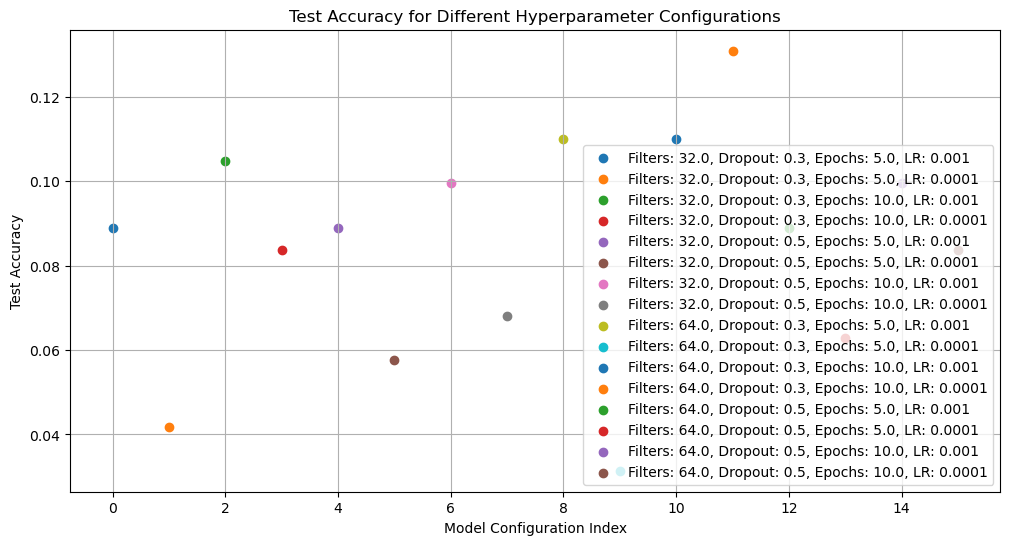

In [44]:

'''
    8) in this function we are creating a CNN with 2 conv layers accompanied by max pooling of 2x2 
        and softmax for classification and dropout layer , here we compile the model and return it. 
'''
def CNN_For_Signatures(input_shape,num_classes,filters=32,kernel_size=(3,3),dropout_rate=0.5,learning_rate=0.001):
    sign_CNN=Sequential()
    sign_CNN.add(Input(shape=input_shape))
    sign_CNN.add(Conv2D(filters, kernel_size,activation='relu'))
    sign_CNN.add(MaxPooling2D((2,2)))
    sign_CNN.add(Conv2D(filters*2, kernel_size, activation='relu'))
    sign_CNN.add(MaxPooling2D((2,2)))
    sign_CNN.add(Flatten())
    sign_CNN.add(Dense(128,activation='relu'))
    sign_CNN.add(Dropout(dropout_rate))
    sign_CNN.add(Dense(num_classes,activation='softmax'))
    optimizer=Adam(learning_rate=learning_rate)
    sign_CNN.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=['accuracy'])
    return sign_CNN


'''
    9)- Here we first normalize the images and labels to categorical the spilt and apply various options for finding out 
    the best ones
'''
def Grid_search_for_CNN():
    signs,labels,num_classes=Loading_Data('Data/Processed_Signatures')
    signs=signs/255.0
    labels=to_categorical(labels, num_classes=num_classes)
    X_train,X_test,y_train,y_test=train_test_split(signs,labels,test_size=0.2,random_state=42)
    # Hyperparameters for testing out the best ones
    filter_options=[32,64]
    dropout_options=[0.3, 0.5]
    epochs_options=[5, 10]
    learning_rate_options=[0.001, 0.0001]
    best_acc=0
    best_params={}
    results=[]
    for filters in filter_options:
        for dropout_rate in dropout_options:
            for epochs in epochs_options:
                for learning_rate in learning_rate_options:
                    Sign_CNN=CNN_For_Signatures(input_shape=(sign_size[0],sign_size[1],1),num_classes=num_classes,filters=filters,dropout_rate=dropout_rate,learning_rate=learning_rate)
                    CNN_history=Sign_CNN.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=epochs,verbose=0)
                    test_loss,test_accuracy=Sign_CNN.evaluate(X_test,y_test,verbose=0)
                    results.append((filters,dropout_rate,epochs,learning_rate,test_accuracy))
                    print(f"Filters:{filters},Dropout Rate:{dropout_rate},Epochs: {epochs}",f"Learning Rate: {learning_rate}",f"Test Accuracy:{test_accuracy*100:.2f}%")
                    if test_accuracy>best_acc:
                        best_acc=test_accuracy
                        best_params={'filters':filters,'dropout_rate':dropout_rate,'epochs': epochs,'learning_rate':learning_rate}
    print("Best parameters:",best_params)
    print(f"Best test accuracy:{best_acc*100:.2f}%")

    # Plotting the results
    results=np.array(results)
    plt.figure(figsize=(12,6))
    for i,(filters, dropout_rate,epochs,learning_rate, acc) in enumerate(results):
        plt.scatter(i, acc, label=f'Filters: {filters}, Dropout: {dropout_rate}, Epochs: {epochs}, LR: {learning_rate}')
    plt.xlabel('Model Configuration Index')
    plt.ylabel('Test Accuracy')
    plt.title('Test Accuracy for Different Hyperparameter Configurations')
    plt.legend()
    plt.grid()
    plt.show()

Grid_search_for_CNN()


Best results = Filters: 64, Dropout Rate: 0.3, Epochs: 10, Learning Rate: 0.0001, Test Accuracy: 13.09%


### &nbsp; 2.2.2 TRAINING CNN ON BEST PARAMETERS
Simply like above but with visualizations of accuracy from history i.e. both validation and training accuracy , precision recall, f1 score<br>
along with confusion matrix which is not a feasible approach as there are too many classes<br>


In [10]:
'''
    10)- train similarly to above using best parameters
    
'''
def Train_Sign_CNN(path):
    signs,labels,num_classes=Loading_Data(path)
    signs=signs/255.0
    labels=to_categorical(labels,num_classes=num_classes)
    X_train,X_test,y_train,y_test=train_test_split(signs,labels,test_size=0.2,random_state=42)
    Sign_CNN=CNN_For_Signatures(input_shape=(sign_size[0],sign_size[1],1),num_classes=num_classes,filters=64,dropout_rate=0.3,learning_rate=0.001)
    batch_size=32
    history=Sign_CNN.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=50)
    y_pred=Sign_CNN.predict(X_test)
    y_pred_classes=np.argmax(y_pred,axis=1)
    y_true=np.argmax(y_test,axis=1)
    test_loss,test_accuracy=Sign_CNN.evaluate(X_test,y_test)
    print(f"Test accuracy: {test_accuracy*100:.2f}%")

    
    print(f"Accuracy: {accuracy_score(y_true,y_pred_classes)*100:.2f}%")
    print(f"Precision: {precision_score(y_true,y_pred_classes, average='weighted')*100:.2f}%")
    print(f"Recall: {recall_score(y_true,y_pred_classes,average='weighted')*100:.2f}%")
    print(f"F1-Score: {f1_score(y_true,y_pred_classes,average='weighted')*100:.2f}%")

    # PLOTTING
    plt.figure(figsize=(12,4))

    # displaying Accuracy plot
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'],label='Train Accuracy')
    plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # displaying Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'],label='Train Loss')
    plt.plot(history.history['val_loss'],label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # displaying Confusion Matrix
    con_mat=confusion_matrix(y_true,y_pred_classes)
    plt.figure(figsize=(10,7))
    plt.imshow(con_mat,interpolation='nearest',cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks=np.arange(num_classes)
    plt.xticks(tick_marks,[f'Class {i}' for i in range(num_classes)],rotation=45)
    plt.yticks(tick_marks,[f'Class {i}' for i in range(num_classes)])
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 18s 608ms/step - accuracy: 0.0067 - loss: 5.3080 - val_accuracy: 0.0157 - val_loss: 5.2542
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 521ms/step - accuracy: 0.0853 - loss: 5.1536 - val_accuracy: 0.0052 - val_loss: 5.1747
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 594ms/step - accuracy: 0.1853 - loss: 4.1386 - val_accuracy: 0.0995 - val_loss: 4.9810
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 570ms/step - accuracy: 0.5927 - loss: 2.0953 - val_accuracy: 0.1257 - val_loss: 4.9934
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 598ms/step - accuracy: 0.7434 - loss: 1.4165 - val_accuracy: 0.1257 - val_loss: 5.8728
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 623ms/step - accuracy: 0.7719 - loss: 1.1996 - val_accuracy: 0.1361 - val_loss: 6.7792
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 599ms/step - accuracy: 0.7915 - loss: 1.1779 - val_accuracy: 0.1099 - val_loss: 7.5231
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 605ms/step - accuracy: 0.7690 - loss: 1.2613 - val_accu

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.0904 - loss: 11.9907
Test accuracy: 10.47%
Accuracy: 10.47%
Precision: 11.74%
Recall: 10.47%
F1-Score: 9.83%


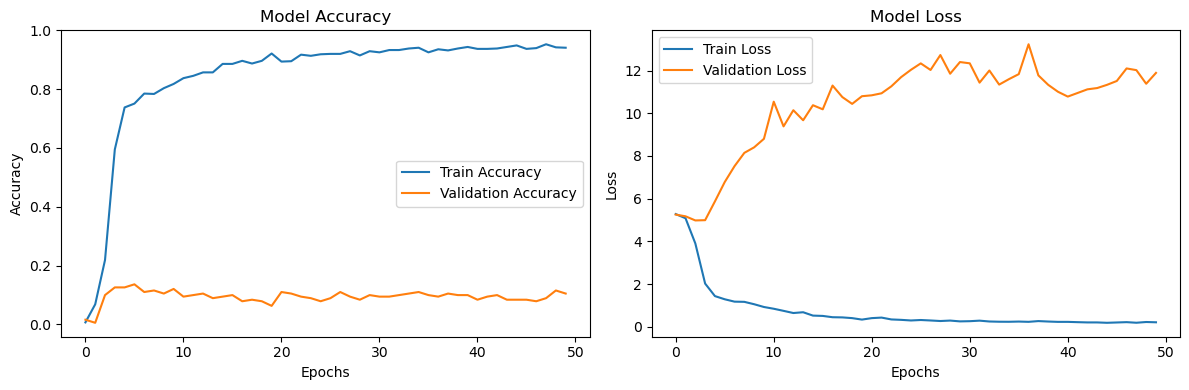

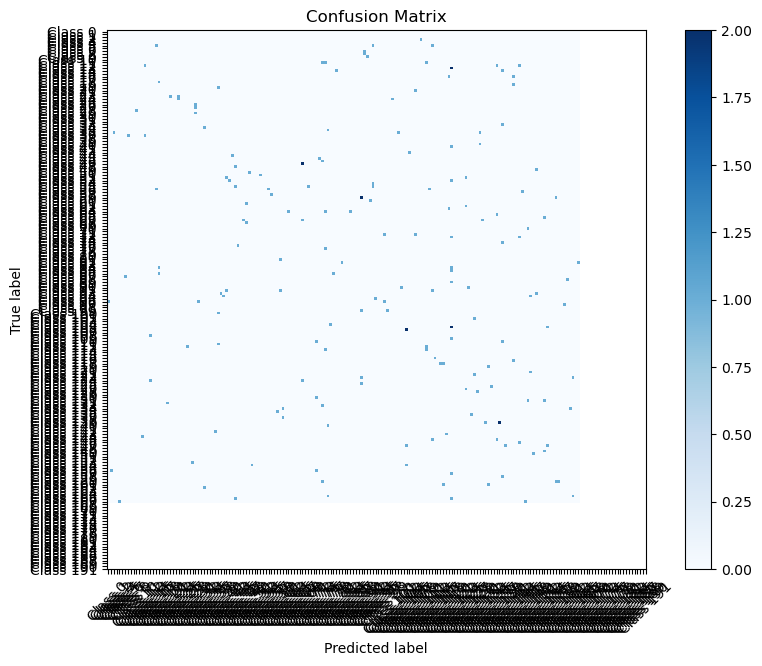

In [11]:
Train_Sign_CNN('Data/Processed_Signatures/')

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 622ms/step - accuracy: 0.0087 - loss: 5.5515 - val_accuracy: 0.0000e+00 - val_loss: 5.2470
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 597ms/step - accuracy: 0.0294 - loss: 5.2112 - val_accuracy: 0.0105 - val_loss: 5.2297
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 604ms/step - accuracy: 0.0317 - loss: 5.1038 - val_accuracy: 0.0105 - val_loss: 5.2198
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 585ms/step - accuracy: 0.0979 - loss: 4.5177 - val_accuracy: 0.0419 - val_loss: 5.0273
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 585ms/step - accuracy: 0.2193 - loss: 3.6332 - val_accuracy: 0.0681 - val_loss: 4.9017
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 580ms/step - accuracy: 0.4040 - loss: 2.6657 - val_accuracy: 0.0838 - val_loss: 4.8351
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 564ms/step - accuracy: 0.5444 - loss: 2.0422 - val_accuracy: 0.0785 - val_loss: 4.7496
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 591ms/step - accuracy: 0.6569 - loss: 1.5577 - val_

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.1139 - loss: 10.1428
Test accuracy: 10.99%
Accuracy: 10.99%
Precision: 11.40%
Recall: 10.99%
F1-Score: 9.67%


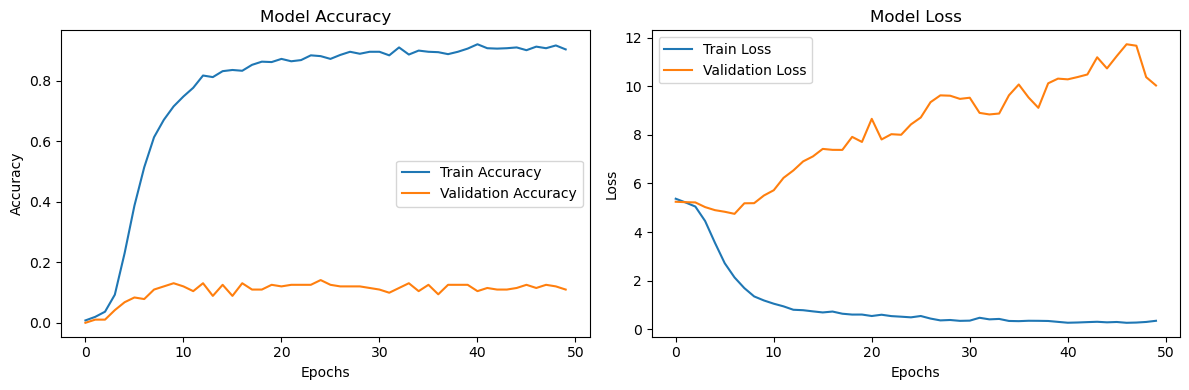

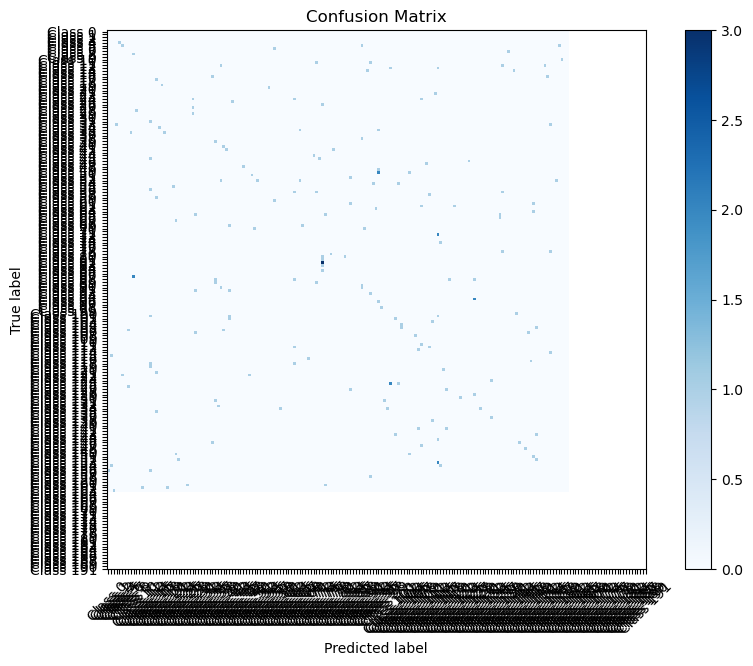

In [12]:
Train_Sign_CNN('Data/Signatures/')

# STEP 3: MANUAL FEATURE EXTRACTION WITH HOG AND SIFT

Same function to be used for both sift and hog

In [16]:
'''
    11)- Creating An ANN function for this step similar to CNN's classifier
'''
def ANN_For_Signatures(input_shape,num_classes):
    Sign_ANN=Sequential()
    Sign_ANN.add(Dense(128,activation='relu',input_shape=(input_shape,)))
    Sign_ANN.add(Dropout(0.3))  
    Sign_ANN.add(Dense(64,activation='relu'))
    Sign_ANN.add(Dense(num_classes,activation='softmax')) 
    return Sign_ANN

'''
   Redefining due to shape issue
'''
def Loading_Data(base):
    signatures=[]
    labels=[]
    person_folders=[folder for folder in os.listdir(base) if os.path.isdir(os.path.join(base, folder))]
    for label,person_folder in enumerate(sorted(person_folders)):
        person_path=os.path.join(base,person_folder)
        for file_name in os.listdir(person_path):
            if file_name.endswith('.png'):
                sign_path=os.path.join(person_path,file_name)
                sign=cv2.imread(sign_path,cv2.IMREAD_GRAYSCALE)
                sign=cv2.resize(sign,sign_size)
                signatures.append(sign)
                labels.append(label)
    
    signatures=np.array(signatures).reshape(-1,sign_size[0],sign_size[1])
    labels=np.array(labels)
    return signatures,labels,len(person_folders)

## 3.1 USING HOG WITH ANN

In [17]:
signs,labels,num_classes=Loading_Data('Data/Processed_Signatures')
print(signs[0].shape)
def HOG_For_Signs(signs):
    hog_signs=[]
    for sign in signs:
        features=hog(sign,pixels_per_cell=(8,8),cells_per_block=(2,2),orientations=9,block_norm='L2-Hys')
        hog_signs.append(features)
    return np.array(hog_signs)



def Training_HOG_ANN(path):
    signs,labels,num_classes=Loading_Data(path)
    hog_signs=HOG_For_Signs(signs)
    hog_signs=hog_signs/np.max(hog_signs)  
    labels=to_categorical(labels,num_classes=num_classes)
    X_train,X_test,y_train,y_test=train_test_split(hog_signs,labels,test_size=0.2,random_state=42)
    input_shape=hog_signs.shape[1]  
    Signs_ann=ANN_For_Signatures(input_shape,num_classes)
    Signs_ann.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    history=Signs_ann.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=50,batch_size=32)
    test_loss,test_accuracy=Signs_ann.evaluate(X_test, y_test)
    print(f"Test accuracy: {test_accuracy*100:.2f}%")

    y_pred=Signs_ann.predict(X_test)
    y_pred_classes=np.argmax(y_pred,axis=1)
    y_true=np.argmax(y_test, axis=1)

    accuracy=accuracy_score(y_true,y_pred_classes)
    precision=precision_score(y_true,y_pred_classes,average='weighted')
    recall=recall_score(y_true,y_pred_classes,average='weighted')
    f1=f1_score(y_true,y_pred_classes,average='weighted')

    print(f"Accuracy: {accuracy*100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")

    print("Classification Report:")
    unique_classes=np.unique(np.concatenate((y_true,y_pred_classes)))
    target_names=[f'Class {i}' for i in unique_classes]
    print(classification_report(y_true,y_pred_classes,labels=unique_classes,target_names=target_names))

    # PLOTTING
    # displaying Confusion Matrix
    con_mat=confusion_matrix(y_true,y_pred_classes)
    plt.figure(figsize=(10,7))
    plt.imshow(con_mat,interpolation='nearest',cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks=np.arange(num_classes)
    plt.xticks(tick_marks, [f'Class {i}' for i in range(num_classes)], rotation=45)
    plt.yticks(tick_marks, [f'Class {i}' for i in range(num_classes)])
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    # Plotting accuracy and loss curves
    plt.figure(figsize=(12,4))

    # displaying Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'],label='Train Accuracy')
    plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # displaying Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'],label='Train Loss')
    plt.plot(history.history['val_loss'],label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


(128, 128)


Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.0033 - loss: 5.3057 - val_accuracy: 0.0000e+00 - val_loss: 5.2433
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0471 - loss: 5.1457 - val_accuracy: 0.0052 - val_loss: 5.2143
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0653 - loss: 4.8427 - val_accuracy: 0.0105 - val_loss: 5.1648
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.1550 - loss: 4.3841 - val_accuracy: 0.0052 - val_loss: 5.1002
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.2760 - loss: 3.8302 - val_accuracy: 0.0366 - val_loss: 4.8411
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3664 - loss: 3.3033 - val_accuracy: 0.0524 - val_loss: 4.7204
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5149 - loss: 2.7629 - val_accuracy: 0.1099 - val_loss: 4.5249
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6153 - loss: 2.3326 - val_accuracy: 0.1257

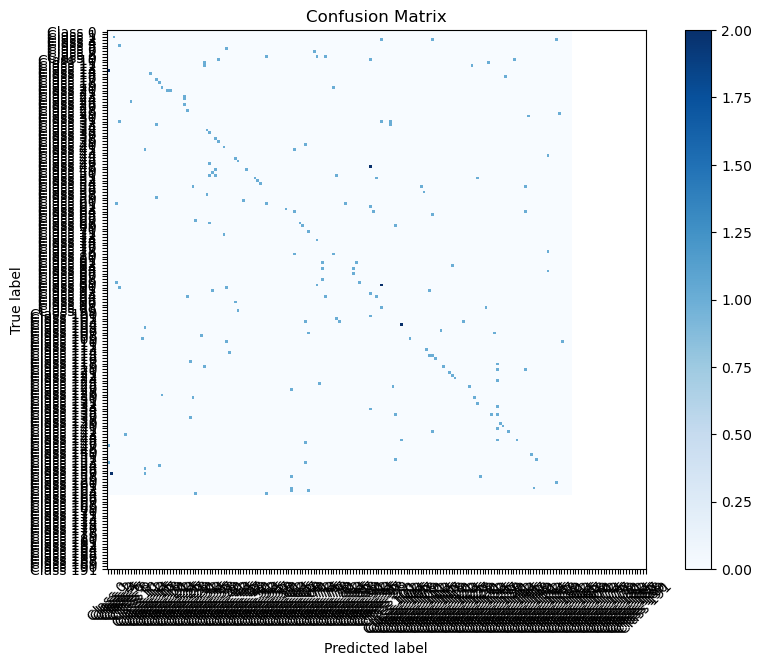

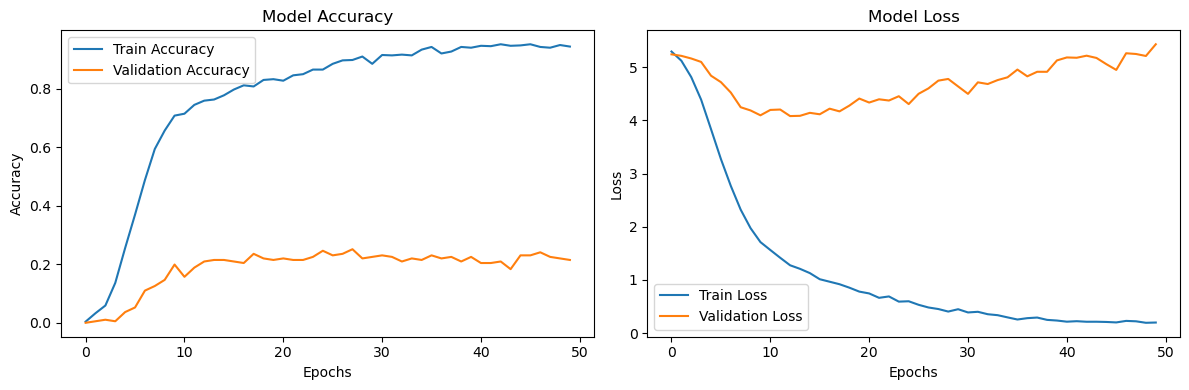

In [18]:
Training_HOG_ANN('Data/Processed_Signatures')

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.0067 - loss: 5.3152 - val_accuracy: 0.0105 - val_loss: 5.2613
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0019 - loss: 5.2618 - val_accuracy: 0.0052 - val_loss: 5.2928
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0087 - loss: 5.2416 - val_accuracy: 0.0000e+00 - val_loss: 5.2994
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0077 - loss: 5.2113 - val_accuracy: 0.0000e+00 - val_loss: 5.2678
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0144 - loss: 5.1882 - val_accuracy: 0.0105 - val_loss: 5.2757
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0097 - loss: 5.1413 - val_accuracy: 0.0000e+00 - val_loss: 5.3307
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0119 - loss: 5.0955 - val_accuracy: 0.0000e+00 - val_loss: 5.2728
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0171 - loss: 4.9756 - val_accu

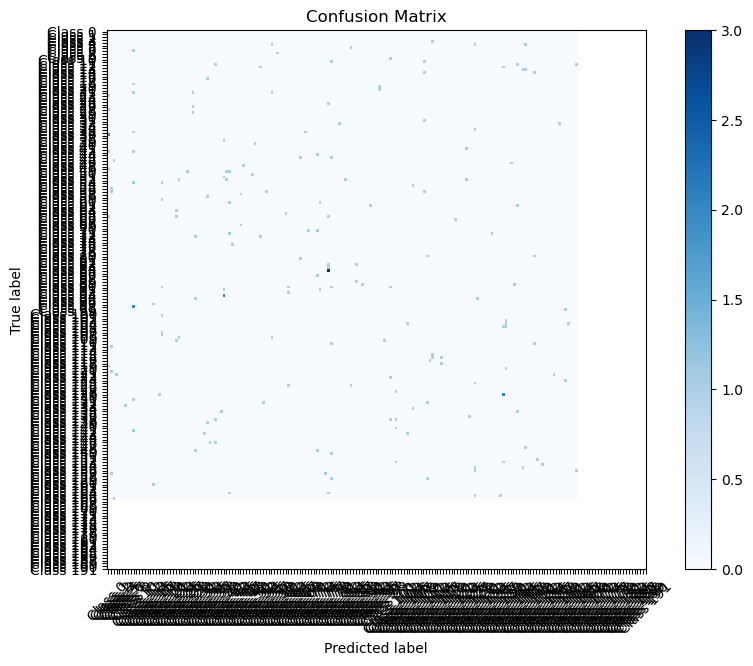

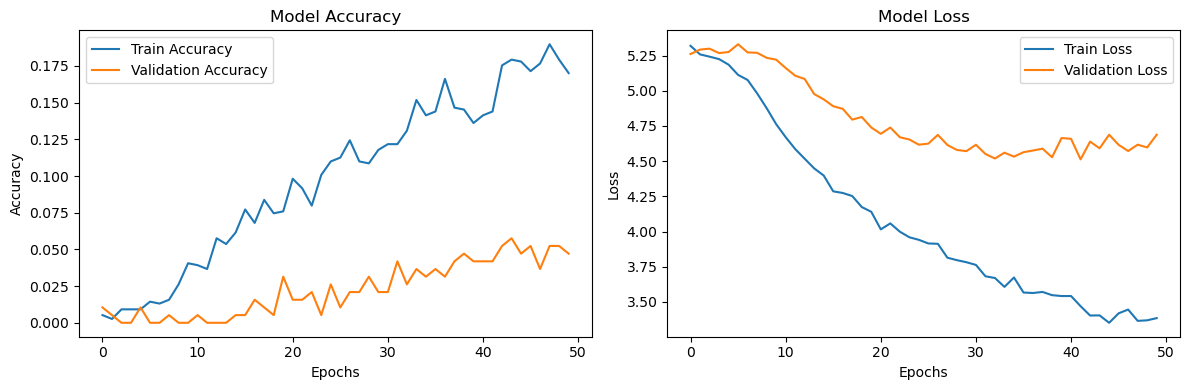

In [19]:
Training_HOG_ANN('Data/Signatures')

## 3.2 SIFT WITH ANN

In [24]:
'''
Like HOG here creating a function for sift with 128 key decriptors
'''
def Sift_For_Signs(images,max_keypoints=128):
    sift_signs=[]
    sift=cv2.SIFT_create() 
    for sign in signs:
        keypoints,descriptors=sift.detectAndCompute(sign,None)
        if descriptors is not None:
            if descriptors.shape[0] > max_keypoints:
                descriptors=descriptors[:max_keypoints,:]
            elif descriptors.shape[0] < max_keypoints:
                padding=np.zeros((max_keypoints-descriptors.shape[0],descriptors.shape[1]))
                descriptors=np.vstack((descriptors,padding))

            sift_signs.append(descriptors.flatten())  
        else:
            sift_signs.append(np.zeros((max_keypoints * 128,)))

    return np.array(sift_signs)


def Training_sift_ANN(path):
    signs,labels,num_classes=Loading_Data(path)
    sift_signs=Sift_For_Signs(signs)
    sift_signs=sift_signs/np.max(sift_signs)  
    labels=to_categorical(labels,num_classes=num_classes)
    X_train,X_test,y_train,y_test=train_test_split(sift_signs,labels,test_size=0.2,random_state=42)
    input_shape=sift_signs.shape[1]  
    Signs_ann=ANN_For_Signatures(input_shape,num_classes)
    Signs_ann.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    history=Signs_ann.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=50,batch_size=32)
    test_loss,test_accuracy=Signs_ann.evaluate(X_test, y_test)
    print(f"Test accuracy: {test_accuracy*100:.2f}%")

    y_pred=Signs_ann.predict(X_test)
    y_pred_classes=np.argmax(y_pred,axis=1)
    y_true=np.argmax(y_test, axis=1)

    accuracy=accuracy_score(y_true,y_pred_classes)
    precision=precision_score(y_true,y_pred_classes,average='weighted')
    recall=recall_score(y_true,y_pred_classes,average='weighted')
    f1=f1_score(y_true,y_pred_classes,average='weighted')

    print(f"Accuracy: {accuracy*100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")

    print("Classification Report:")
    unique_classes=np.unique(np.concatenate((y_true,y_pred_classes)))
    target_names=[f'Class {i}' for i in unique_classes]
    print(classification_report(y_true,y_pred_classes,labels=unique_classes,target_names=target_names))

    # PLOTTING
    # displaying Confusion Matrix
    con_mat=confusion_matrix(y_true,y_pred_classes)
    plt.figure(figsize=(10,7))
    plt.imshow(con_mat,interpolation='nearest',cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks=np.arange(num_classes)
    plt.xticks(tick_marks, [f'Class {i}' for i in range(num_classes)], rotation=45)
    plt.yticks(tick_marks, [f'Class {i}' for i in range(num_classes)])
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    # Plotting accuracy and loss curves
    plt.figure(figsize=(12,4))

    # displaying Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'],label='Train Accuracy')
    plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # displaying Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'],label='Train Loss')
    plt.plot(history.history['val_loss'],label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.0017 - loss: 5.2844 - val_accuracy: 0.0052 - val_loss: 5.2501
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.0254 - loss: 5.1428 - val_accuracy: 0.0052 - val_loss: 5.2291
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.0413 - loss: 4.9086 - val_accuracy: 0.0052 - val_loss: 5.2742
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.0493 - loss: 4.7165 - val_accuracy: 0.0052 - val_loss: 5.3329
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.0994 - loss: 4.3522 - val_accuracy: 0.0052 - val_loss: 5.3012
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.1592 - loss: 4.1399 - val_accuracy: 0.0105 - val_loss: 5.3448
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.2441 - loss: 3.8173 - val_accuracy: 0.0052 - val_loss: 5.3882
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.3213 - loss: 3.4394 - val_accuracy: 0.0052 - v

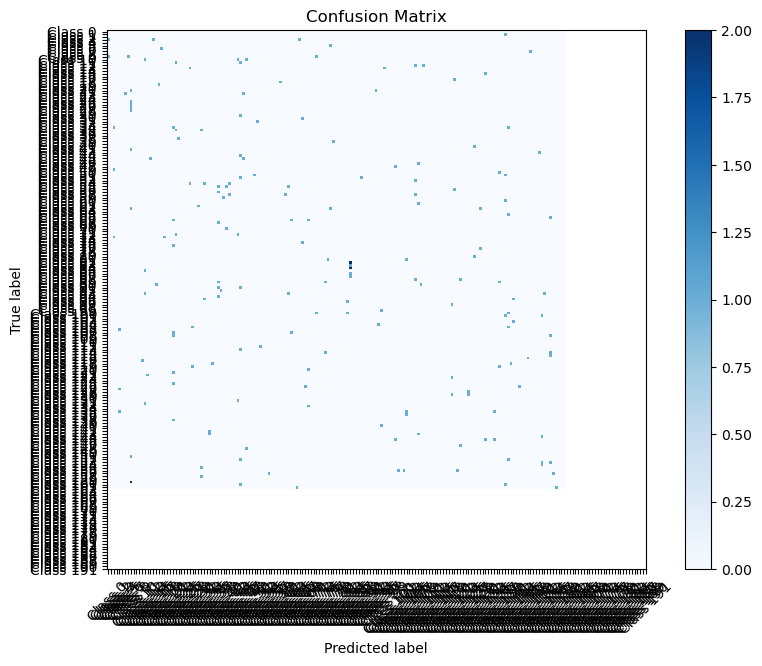

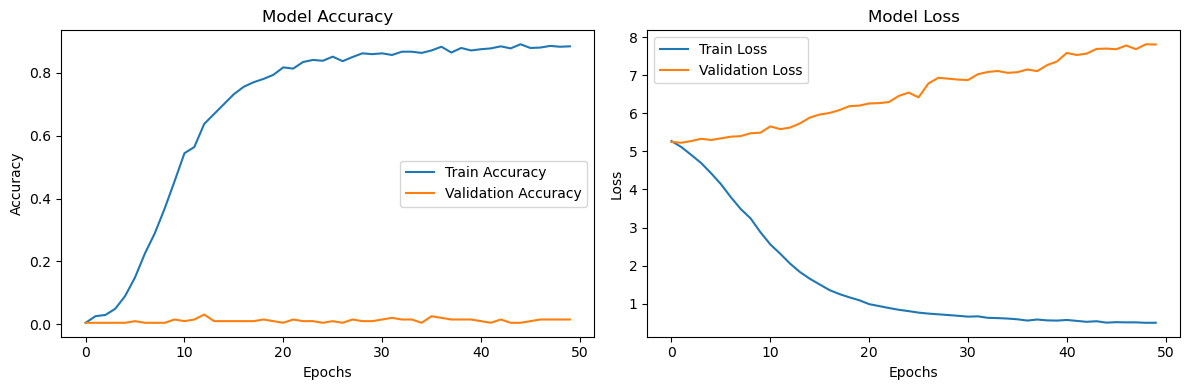

In [25]:
Training_sift_ANN('Data/Processed_Signatures/')

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.0032 - loss: 5.3512 - val_accuracy: 0.0052 - val_loss: 5.2653
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0014 - loss: 5.2399 - val_accuracy: 0.0052 - val_loss: 5.2574
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0146 - loss: 5.2187 - val_accuracy: 0.0000e+00 - val_loss: 5.2773
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0040 - loss: 5.1755 - val_accuracy: 0.0052 - val_loss: 5.3001
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0217 - loss: 5.1242 - val_accuracy: 0.0105 - val_loss: 5.3139
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0366 - loss: 5.0548 - val_accuracy: 0.0000e+00 - val_loss: 5.3172
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0360 - loss: 4.9190 - val_accuracy: 0.0052 - val_loss: 5.2246
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.0365 - loss: 4.7956 - val_accuracy: 0.

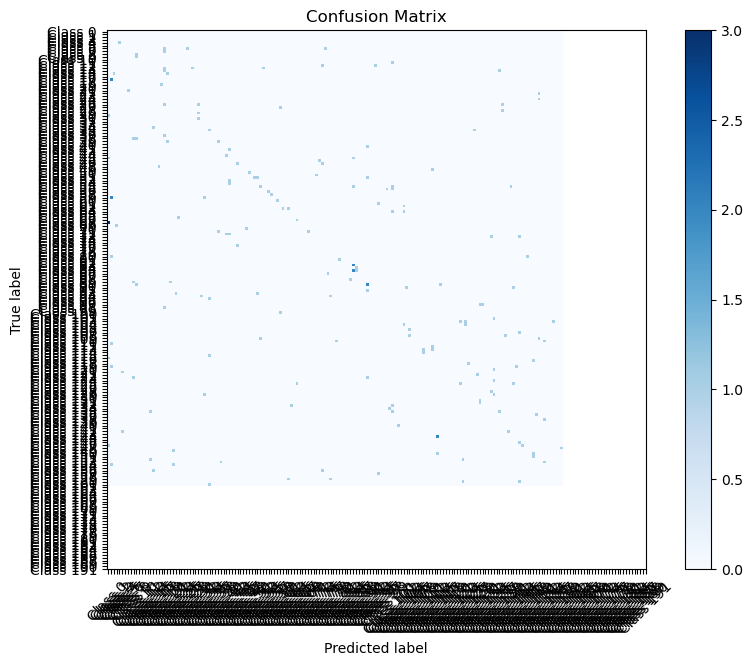

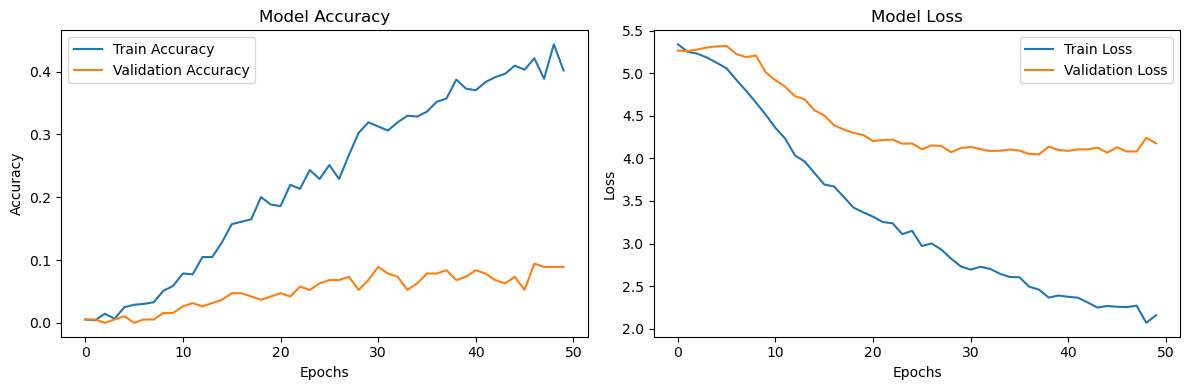

In [27]:
Training_sift_ANN('Data/Signatures/')

*** 
# CONCLUSION
CONCLUSION
CNN which is well known for its performance in clas-
sification tasks ,surprisingly didn’t yield any strong results
due to over fitting. It could also be due to not very good
segmented data. This maybe due to small dataset or task being
too simple in front of CNN. For this task HOG features with
ANN were most suitable after preprocessing the image. SIFT
performance was the worst maybe because the data lacks too
many descriptors. To conclude it all, having a good model like
CNN doesn’t mean good accuracy, it also depends on the data.

End